## Подготовка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

plt.rcParams['figure.figsize'] = [15, 10]

Загрузим данные

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=0, parse_dates=[0])

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


## Анализ

Посмотрим на первое и последнее значение даты, а так же построим график

In [5]:
print(data.index.min())
print(data.index.max())

2018-03-01 00:00:00
2018-08-31 23:50:00


Имеем данные с 1 марта по 31 августа 2018 года

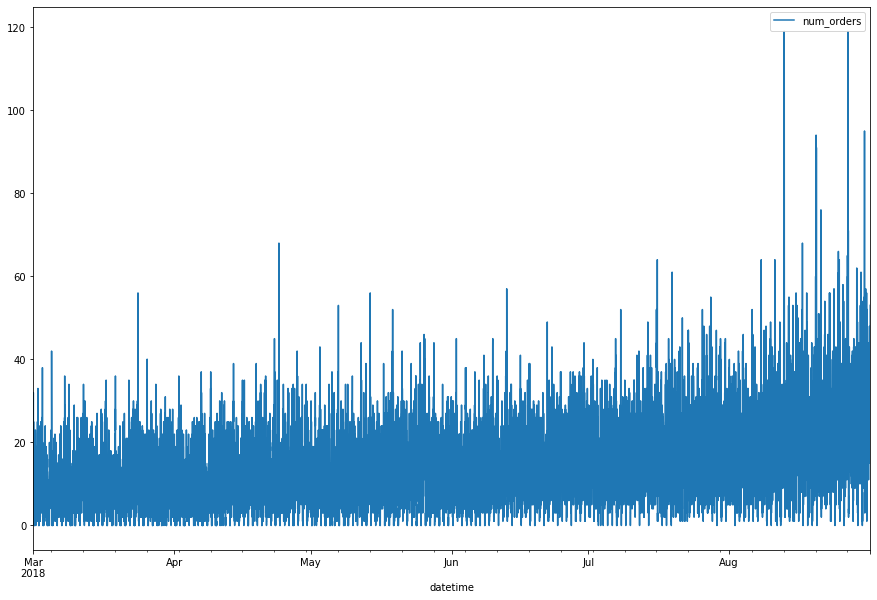

In [6]:
data.plot()
plt.show()

Выполним ресемплирование по одному часу и снова построим график

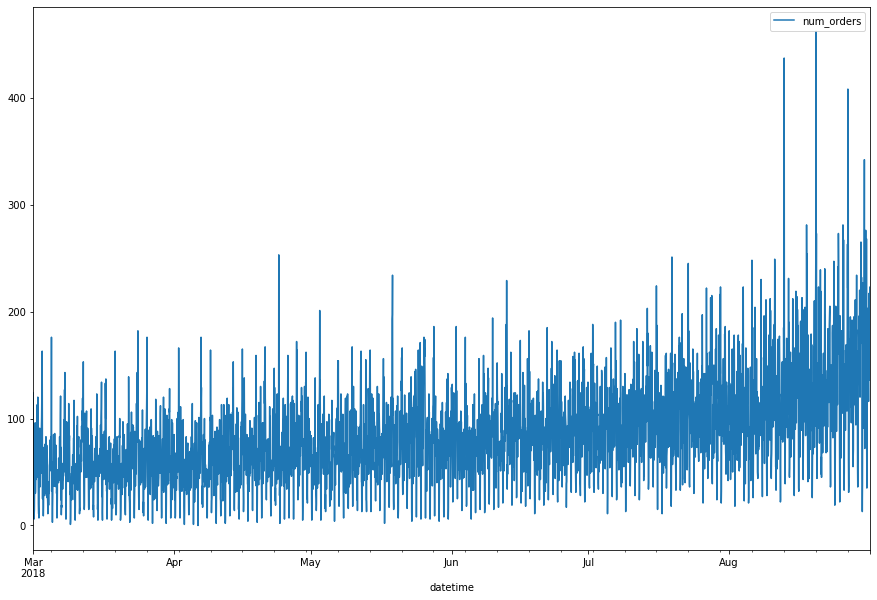

In [7]:
data = data.resample('1H').sum()
data.plot()
plt.show()

Посмотрим на распределение среднего и скользящего отклонения

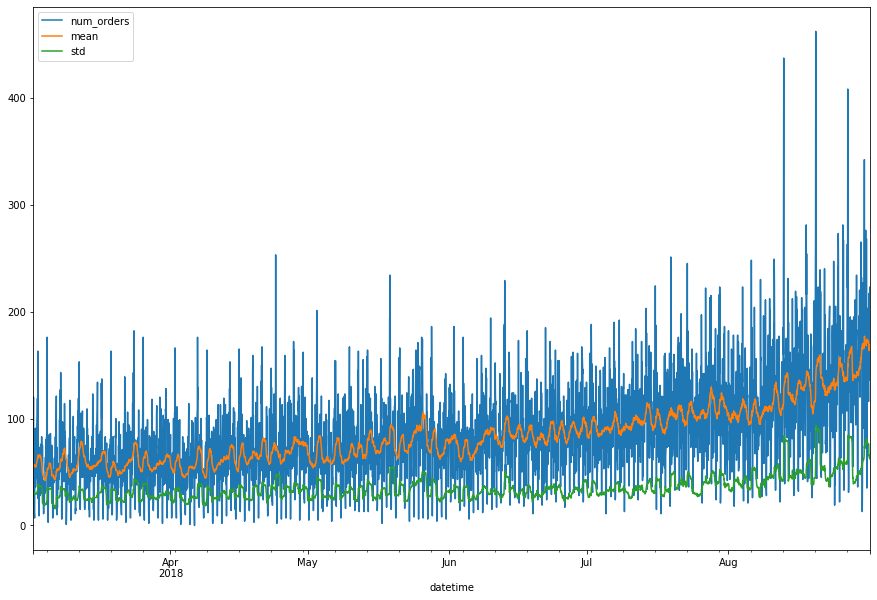

In [8]:
data.sort_index(inplace=True)
data_research = data.copy()
data_research['mean'] = data_research['num_orders'].rolling(24).mean()
data_research['std'] = data_research['num_orders'].rolling(24).std()
data_research.dropna(inplace=True, axis=0)
data_research.plot()
plt.show()

Выполним декомпозицию временного ряда на составляющие

In [9]:
data_decomposed = seasonal_decompose(data)

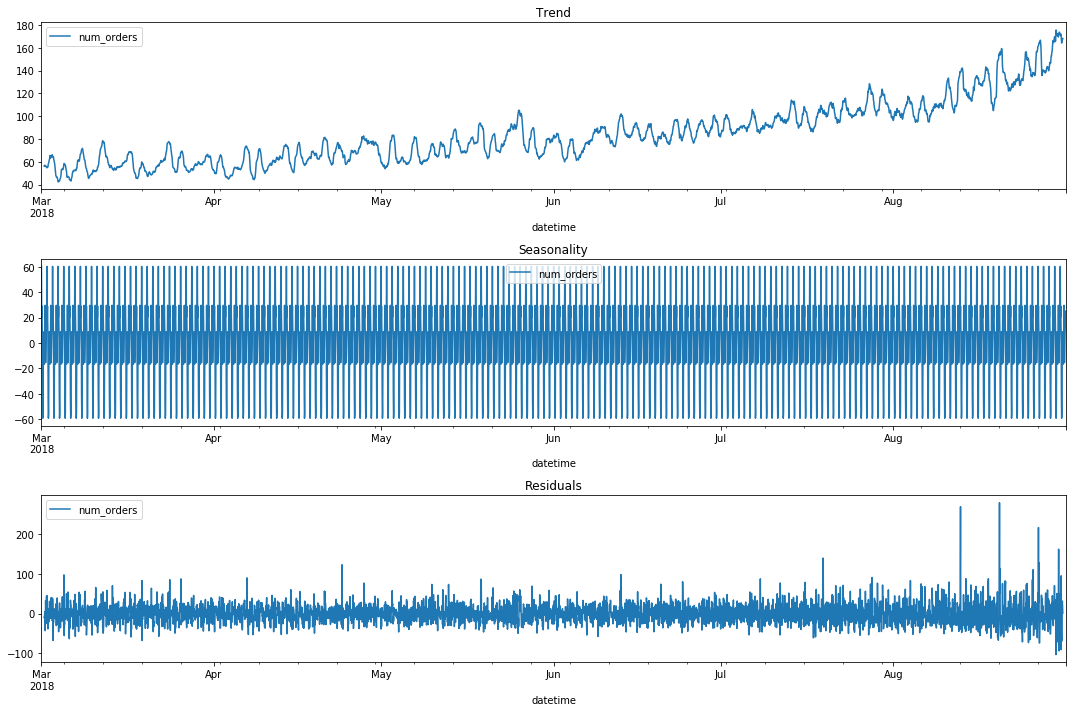

In [10]:
plt.subplot(311)
data_decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
data_decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
data_decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Видим тренд на увеличение числа заказов такси от марта к августу

Данные распределены по часам, поэтому достаточно сложно увидеть сезонность на полной выборке, попробуем взять несколько дней

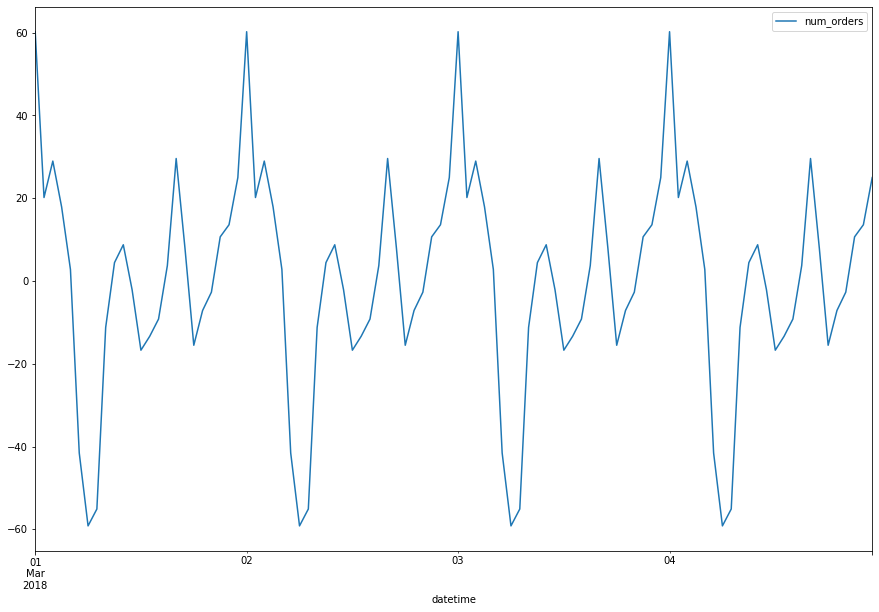

In [11]:
data_decomposed.seasonal['2018-03-01':'2018-03-04'].plot()
plt.show()

Видим, что значения повторяются примерно каждые 24 часа

Перед обучением моделей добавим признаки с месяцем, днем недели, днем месяца.  
Так же добавим скользящее среднее и отстающие значения от 1 до 24

In [12]:
def make_features(window_size, max_lag):
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['rolling_mean'] = data['num_orders'].shift().rolling(window_size).mean()
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data.dropna(inplace=True, axis=0)
    data.sort_index(inplace=True)
    data.head()

In [13]:
make_features(24, 24)

Разделим датасет и сформируем две выборки - обучающую и тестовую

In [14]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [15]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

## Обучение

Для подбора гиперпараметров используем GridSearchCV и Pipeline.

Создадим свою метрику для pipeline

In [16]:
mse = make_scorer(mean_squared_error,greater_is_better=False)

Создадим объект time series split для кросс-валидации

In [17]:
tscv = TimeSeriesSplit(n_splits=5)

Сначала обучим самую простую модель линейной регрессии

In [18]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Обучим модель случайного леса

In [19]:
param_grid_rf = [
    {
        'max_depth': [i for i in range(1, 10, 2)],
        'min_samples_split': [i for i in range(2, 10, 2)]
    }
]

In [20]:
rf_regressor = GridSearchCV(RandomForestRegressor(random_state=42, n_estimators=100), param_grid_rf, scoring=mse, cv=tscv)
rf_pipeline = Pipeline(steps=[('regressor', rf_regressor)])
rf_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('regressor',
                 GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                              error_score='raise-deprecating',
                              estimator=RandomForestRegressor(bootstrap=True,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                              min_samples_split=2,
                                                            

Попробуем воспользоваться моделью из библиотеки lightGBM

In [21]:
param_grid_lgbm = [
    {
        'max_depth': [i for i in range(1, 6, 2)],
        'learning_rate': [0.1, 0.01, 0.2]
    }
]

In [22]:
lgbm_regressor = GridSearchCV(LGBMRegressor(random_state=42), param_grid_lgbm, scoring=mse, cv=tscv)
lgbm_pipeline = Pipeline(steps=[('regressor', lgbm_regressor)])
lgbm_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('regressor',
                 GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                              error_score='raise-deprecating',
                              estimator=LGBMRegressor(boosting_type='gbdt',
                                                      class_weight=None,
                                                      colsample_bytree=1.0,
                                                      importance_type='split',
                                                      learning_rate=0.1,
                                                      max_depth=-1,
                                                      min_child_samples=20,
                                                      min_child_weight=0.001,
                                                      min_split_gain=0.0,
                                                      n_estimator...
                                                      random

Модели обучены, перейдем к анализу результатов

## Тестирование

In [23]:
lr_model_pred = lr_model.predict(X_test)
lr_model_score = mean_squared_error(y_test, lr_model_pred) ** (1/2)
print(f'RMSE для линейной регрессии: {lr_model_score}')

RMSE для линейной регрессии: 45.54244745506205


In [24]:
rf_pred = rf_pipeline.predict(X_test)
rf_model_score = mean_squared_error(y_test, rf_pred) ** (1/2)
print(f'RMSE для случайного леса: {rf_model_score}')

RMSE для случайного леса: 43.84586824210383


In [25]:
lgbm_pred = lgbm_pipeline.predict(X_test)
lgbm_model_score = mean_squared_error(y_test, lgbm_pred) ** (1/2)
print(f'RMSE для модели из lightGBM: {lgbm_model_score}')

RMSE для модели из lightGBM: 42.561494602197996


Теперь визуализируем предсказания для каждой из моделей

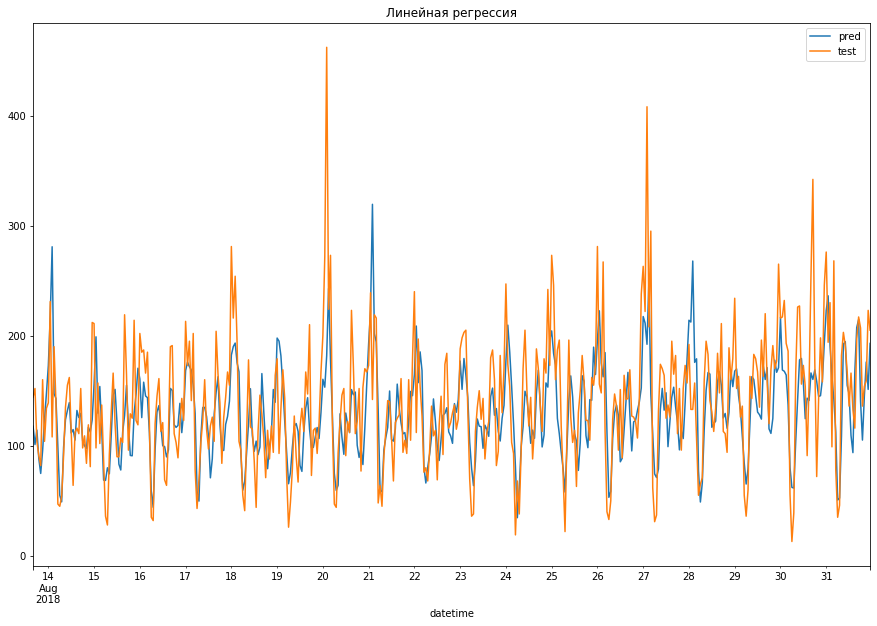

In [52]:
lr_model_pred_df = pd.DataFrame(data=lr_model_pred, columns=['pred'], index=X_test.index)
lr_model_pred_df['test'] = y_test
lr_model_pred_df.plot()
plt.title('Линейная регрессия')
plt.show()

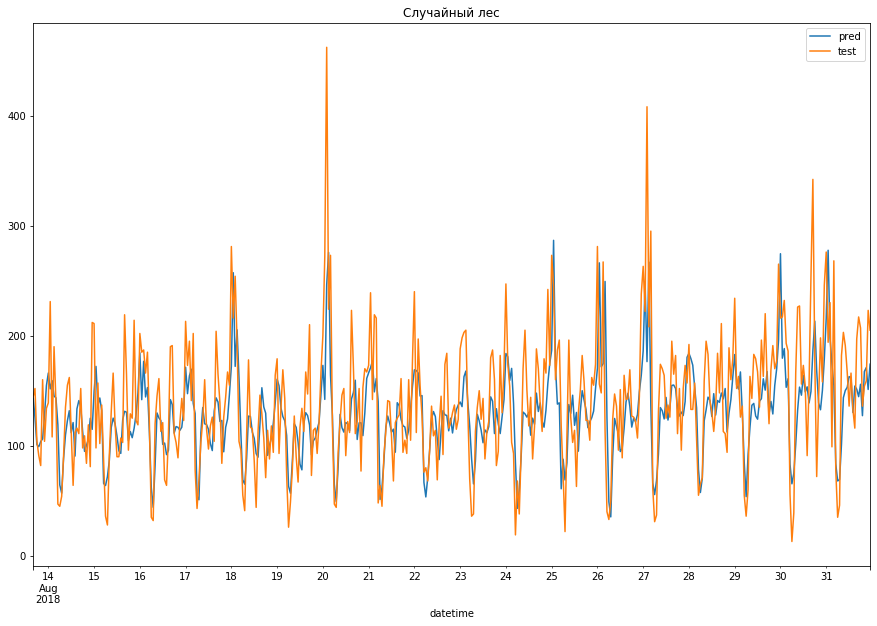

In [47]:
rf_pred_df = pd.DataFrame(data=rf_pred, columns=['pred'], index=X_test.index)
rf_pred_df['test'] = y_test
rf_pred_df.plot()
plt.title('Случайный лес')
plt.show()

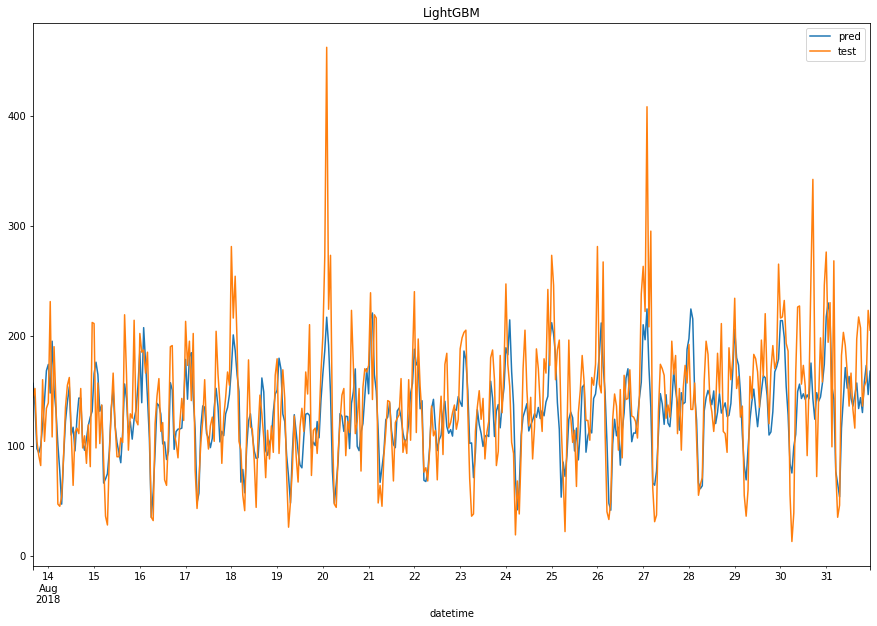

In [53]:
lgbm_pred_df = pd.DataFrame(data=lgbm_pred, columns=['pred'], index=X_test.index)
lgbm_pred_df['test'] = y_test
lgbm_pred_df.plot()
plt.title('LightGBM')
plt.show()

## Выводы

В целом, модели показали близкие значения метрики, лучшего результата можно добиться если подробнее изучить сезонность, подобрать размер окна и гиперпараметры моделей.  
Наилучший результата метрики RMSE показала модель lightGBMRegressor. Для решения задачи выберем её.